In [6]:
import Functions as code
import numpy as np
import matplotlib.pyplot as plt

seed = 42
small_figsize = (8, 6)


In [4]:
from sklearn.model_selection import train_test_split

x, y, y_noise = code.dataset(n=18,seed=seed)



In [39]:
from Functions import polynomial_features
Layers = [0,1,2,3]
LayerNodes = [5,10,25,50]

ok = Layers[0] * [LayerNodes[2]] + [1]
print(ok)

test = polynomial_features(x, 5)
print(test[2])

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"], # This matches LaTeX's default font
    "font.size": 11,                       # This matches the 11pt in \documentclass
})


[1]
[-0.95959596  0.92082441 -0.88361938  0.84791759 -0.81365829]


c:\Users\Anton\Documents\UiO Fag\FYS-STK4155 Anvendt dataanalyse og maskinlæring\Eget Arbeid\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


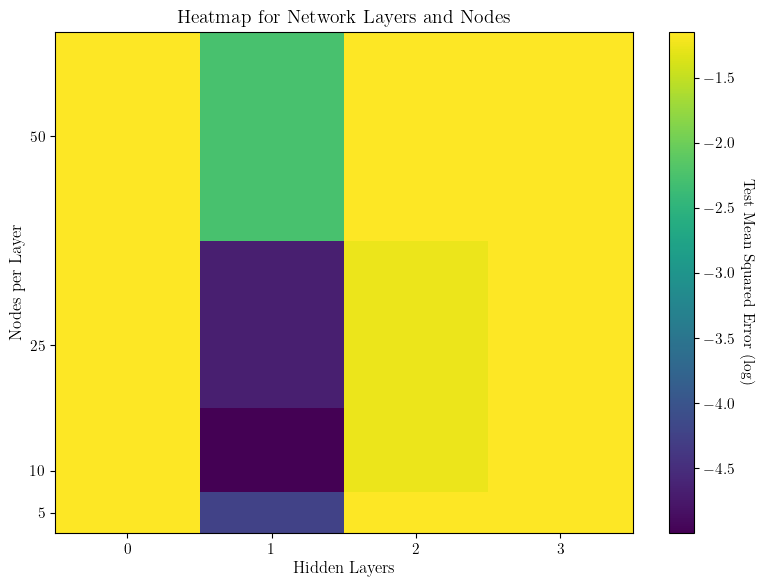

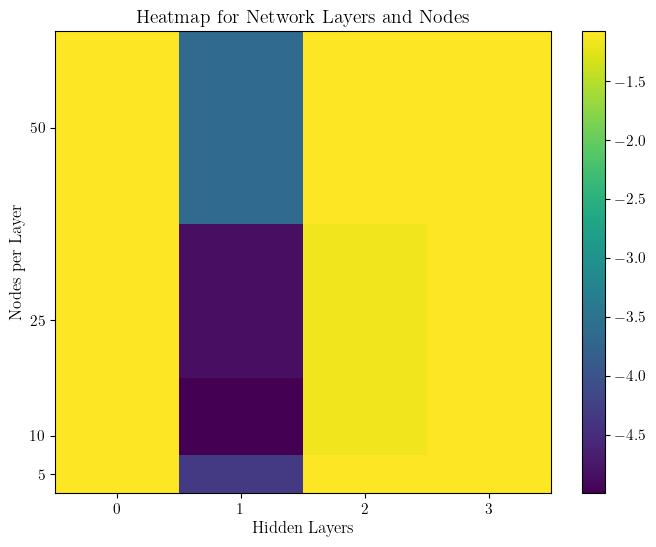

In [63]:
from Functions import (
    create_layers_batch,
    backpropagation_batch,
    sigmoid,
    softmax,
    sigmoid_der,
    der_softmax,
    ReLU,
    ReLU_der,
    polynomial_features,
    mse,
    der_mse,
    feed_forward_saver_batch
)
from sklearn.preprocessing import StandardScaler


def linear_activation(z):
    return z
def linear_activation_der(z):
    return np.ones_like(z)

x, y, y_noise = code.dataset(n=100,seed=seed)

iterations = 10000
learning_rate = 0.05
momentum = 0.99

Layers = [0,1,2,3]
LayerNodes = [5,10,25,50]
mse_matrix = np.zeros((len(LayerNodes), len(Layers)))
mse_matrix_train = np.zeros((len(LayerNodes), len(Layers)))

polynomial_degree = 1
X = polynomial_features(x, polynomial_degree)
X = StandardScaler().fit_transform(X)
y_centered = y - y.mean()
X_train, X_test, y_train, y_test = train_test_split(X, y_centered, test_size=0.2, random_state=seed)
batch_size = len(X_train)


for n_i, hiddenlayers in enumerate(Layers):
    for n_j, nodes in enumerate(LayerNodes):
        activation_funcs = [sigmoid] * (hiddenlayers) + [linear_activation] 
        activation_funcs_der = [sigmoid_der] * (hiddenlayers) + [linear_activation_der]
        layers = create_layers_batch(polynomial_degree, hiddenlayers * [nodes] + [1])

        velocities = []
        for W, b in layers: 
            v_W = np.zeros_like(W)
            v_b = np.zeros_like(b)
            velocities.append((v_W, v_b))

        for i in range(iterations):
            for j in range(0, len(X_train), batch_size):
                x_batch = X_train[j : j + batch_size]
                y_batch = y_train[j : j + batch_size]

                layer_grads = backpropagation_batch(
                    x_batch, layers, activation_funcs, y_batch, activation_funcs_der, cost_der=der_mse
                )

                # Update weights and biases using gradient descent
                for k in range(len(layers)):
                    W, b = layers[k]
                    dC_dW, dC_db = layer_grads[k]
                    v_W, v_b = velocities[k]

                    v_W = momentum * v_W + learning_rate * dC_dW
                    v_b = momentum * v_b + learning_rate * np.mean(dC_db, axis=0, keepdims=True)

                    W -= v_W
                    b -= v_b
                    layers[k] = (W, b)
                    velocities[k] = (v_W, v_b)
        _,_, a_test = feed_forward_saver_batch(X_test, layers, activation_funcs)
        score = np.mean((a_test - y_test)**2)
        mse_matrix[n_j, n_i] = score

        _,_, a_train = feed_forward_saver_batch(X_train, layers, activation_funcs)
        score_train = np.mean((a_train - y_train)**2)
        mse_matrix_train[n_j, n_i] = score_train

plot_mse = np.log10(mse_matrix)
plot_mse_train = np.log10(mse_matrix_train)
fig, ax = plt.subplots(figsize=small_figsize)

c = ax.pcolormesh(Layers, LayerNodes, plot_mse,  cmap='viridis')
ax.set_xticks(Layers)
ax.set_yticks(LayerNodes)
# Set labels and titles
ax.set_title('Heatmap for Network Layers and Nodes', fontsize=14)
ax.set_xlabel('Hidden Layers', fontsize=12)
ax.set_ylabel('Nodes per Layer', fontsize=12)



# Add color bar
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('Test Mean Squared Error (log)', rotation=-90, va="bottom")

# Save the figure
filename = "Heatmap.pdf"
plt.tight_layout()
plt.savefig(filename)
plt.show()

fig, ax = plt.subplots(figsize=small_figsize)
c = ax.pcolormesh(Layers, LayerNodes, plot_mse_train,  cmap='viridis')
ax.set_xticks(Layers)
ax.set_yticks(LayerNodes)
# Set labels and titles
ax.set_title('Heatmap for Network Layers and Nodes', fontsize=14)
ax.set_xlabel('Hidden Layers', fontsize=12)
ax.set_ylabel('Nodes per Layer', fontsize=12)
cbar = fig.colorbar(c, ax=ax)
plt.show()


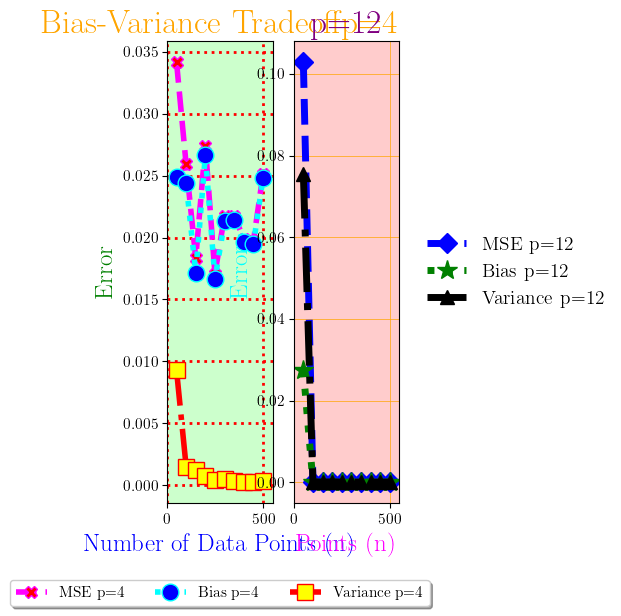

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    PolynomialFeatures,
)  # use the fit_transform method of the created object!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
np.random.seed(2018)
bootstraps = 100
datapoints = np.arange(50, 501, 50)
p = 12



biases = []
variances = []
mses = []

for p in [4, 12]:
    for n in datapoints:
        x = np.linspace(-3, 3, n)
        y = np.exp(-(x**2)) + 1.5 * np.exp(-((x - 2) ** 2)) + np.random.normal(0, 0.1)
        X = PolynomialFeatures(degree=p).fit_transform(x.reshape(-1, 1))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        predictions = np.zeros((bootstraps, len(y_test)))
        targets = np.zeros((bootstraps, len(y_test)))
        for b in range(bootstraps):
           X_train_re, y_train_re = resample(X_train, y_train)
           model = LinearRegression().fit(X_train_re, y_train_re)
           # make predictions on the test data
           predictions[b, :] = model.predict(X_test)
           targets[b, :] = y_test
        biases.append(np.mean((np.mean(predictions, axis=0) - np.mean(targets, axis=0)) ** 2))
        variances.append(np.mean(np.var(predictions, axis=0)))
        mses.append(mean_squared_error(predictions, targets))

indeks = len(datapoints) 

fig, axes = plt.subplots(1, 2, figsize=(3, 6))


ax1 = axes[0]
ax1.set_facecolor('#CCFFCC') # Light green
ax1.plot(datapoints, mses[:indeks], label="MSE p=4", 
         c='magenta', ls='--', lw=4, marker='X', markersize=9, mfc='red')
ax1.plot(datapoints, biases[:indeks], label="Bias p=4", 
         c='cyan', ls=':', lw=4, marker='o', markersize=12, mfc='blue')
ax1.plot(datapoints, variances[:indeks], label="Variance p=4", 
         c='red', ls='-.', lw=4, marker='s', markersize=12, mfc='yellow')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fancybox=True, shadow=True)
ax1.set_title("Bias-Variance Tradeoffp=4", fontsize=24, color='orange')
ax1.set_xlabel("Number of Data Points (n)", fontsize=18, color='blue')
ax1.set_ylabel("Error", fontsize=18, color='green')
ax1.set_xlim(0, 550)
ax1.grid(True, linestyle=':', color='red', linewidth=2)

# --- Plot 2: p=12 ---
# Note: Fixed the indexing bug from your example [indeks+1:] -> [indeks:]
ax2 = axes[1]
ax2.set_facecolor('#FFCCCC') # Light red
ax2.plot(datapoints, mses[indeks:], label="MSE p=12", 
         c='blue', ls='--', lw=5, marker='D', markersize=10)
ax2.plot(datapoints, biases[indeks:], label="Bias p=12", 
         c='green', ls=':', lw=5, marker='*', markersize=15)
ax2.plot(datapoints, variances[indeks:], label="Variance p=12", 
         c='black', ls='-.', lw=5, marker='^', markersize=10)
ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=14, frameon=False)
ax2.set_title("p=12", fontsize=24, color='purple')
ax2.set_xlabel("Points (n)", fontsize=18, color='magenta')
ax2.set_ylabel("Error", fontsize=18, color='cyan')
ax2.set_xlim(0, 550) # <-- ADDED THIS LINE
ax2.grid(True, linestyle='-', color='orange', linewidth=0.5)

# Intentionally avoid tight_layout() to make it look cramped
# plt.tight_layout() 
filename = "pretty.pdf"

plt.savefig(filename, bbox_inches='tight')
plt.show()
